In [1]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image, ImageEnhance
from typing import Optional

import trimesh
import pyrender
from pyrender.constants import RenderFlags

def norm(v: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

class Scene:
    def __init__(self, mesh, image_width: int = 640, image_height: int = 480) -> None:

        self.image_width = image_width
        self.image_height = image_height
        
        naruto_mesh = pyrender.Mesh.from_trimesh(mesh)
        naruto_pose = np.eye(4)
        naruto_pose[1, 3] = -1
        
        self.pyrender_scene = pyrender.Scene(ambient_light=[0.5, 0.5, 0.5])
        self.pyrender_scene.add(naruto_mesh, pose=naruto_pose)
        
        self.renderer = pyrender.OffscreenRenderer(image_width, image_height)
        camera = pyrender.PerspectiveCamera(yfov = np.pi / 3.0, aspectRatio=1.0)
        self.camera_node = pyrender.Node(camera=camera)
        self.pyrender_scene.add_node(self.camera_node)

        self.point_clouds = []

        self.T = np.array([
            [1, 0, 0],
            [0, -1, 0],
            [0, 0, -1]
        ])
        
    def add_points(self, points: np.ndarray, radius: float = 0.01, color: list[float] = [0, 0, 0.5]) -> None:
        sm = trimesh.creation.uv_sphere(radius=radius)
        sm.visual.vertex_colors = color
        tfs = np.tile(np.eye(4), (len(points), 1, 1))
        tfs[:,:3,3] = points
        pts = pyrender.Mesh.from_trimesh(sm, poses=tfs)
        node = self.pyrender_scene.add(pts)
        self.point_clouds.append(node)

    def remove_all_points(self) -> None:
        for ptsc in self.point_clouds:
            self.pyrender_scene.remove_node(ptsc)
        self.point_clouds = []
        
    def sample(self, alpha: Optional[float] = None, beta: Optional[float] = None, gamma: Optional[float] = None, return_depth: bool = False) -> [Image.Image, np.ndarray, np.ndarray]:
        rand = np.random.uniform(0, 360, (3)) * np.pi / 180
        if alpha == None:
            alpha = rand[0]
        else:
            alpha *= np.pi / 180
        if beta == None:
            beta = rand[1]
        else:
            beta *= np.pi / 180
        if gamma ==  None:
            gamma = rand[2]
        else:
            gamma *= np.pi / 180
        Rx = np.array([
                            [1, 0, 0, 0],
                            [0, np.cos(alpha), -np.sin(alpha), 0],
                            [0, np.sin(alpha), np.cos(alpha), 0],
                            [0, 0, 0, 1]]
                        )
        Ry = np.array([
                            [np.cos(beta), 0, np.sin(beta), 0],
                            [0, 1, 0, 0],
                            [-np.sin(beta), 0, np.cos(beta), 0],
                            [0, 0, 0, 1]]
                        )
        Rz = np.array([
                            [np.cos(gamma), -np.sin(gamma), 0, 0],
                            [np.sin(gamma), np.cos(gamma), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]
                        )
        camera_pose = Rx @ Ry @ Rz @ np.array([
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 2],
                            [0, 0, 0, 1]]
                        )
        self.pyrender_scene.set_pose(self.camera_node, camera_pose)
        color, depth = self.renderer.render(self.pyrender_scene)
        image = Image.fromarray(color)
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(2.0)
        if not return_depth:
            depth[depth > 0] = 1
        return image, camera_pose, depth

    def intrinsics_matrix(self):

        P = self.camera_node.camera.get_projection_matrix()
        fx = P[0, 0] * self.image_width / 2
        fy = P[1, 1] * self.image_height / 2
        cx = (1.0 - P[0, 2]) * self.image_width / 2
        cy = (1.0 + P[1, 2]) * self.image_height / 2
    
        K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    
        return K

mesh = trimesh.load("./Naruto/Naruto.obj", force="mesh")
scene = Scene(mesh = mesh)

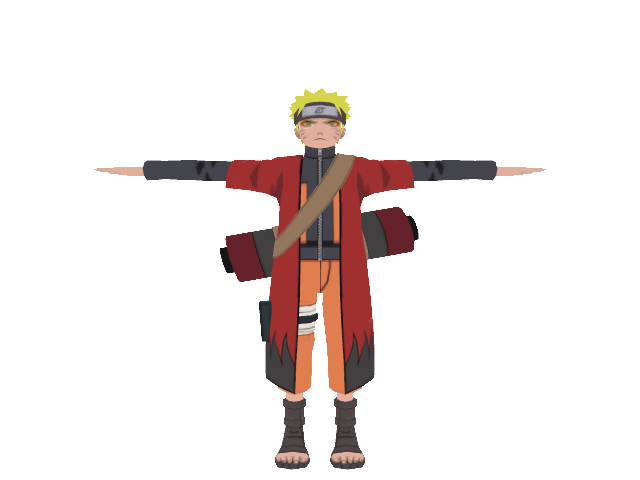

In [25]:
img, pose, depth = scene.sample(0, 0, 0, return_depth=True)
img

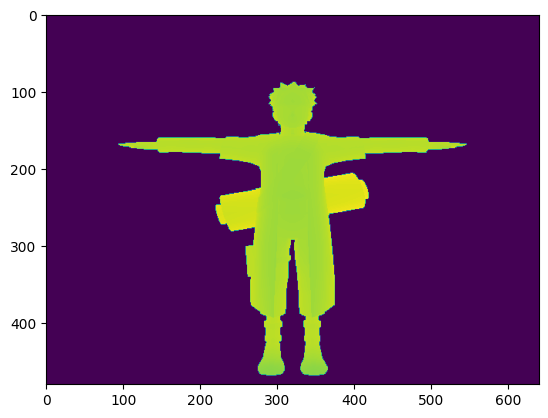

In [26]:
plt.imshow(depth)

In [27]:
K = scene.intrinsics_matrix()

_fx = K[0, 0]
_fy = K[1, 1]
_cx = K[0, 2]
_cy = K[1, 2]

mask = np.where(depth > 0)
x, y = mask[1], mask[0]

normalized_x = x.astype(np.float32) - _cx
normalized_y = y.astype(np.float32) - _cy

world_x = normalized_x * depth[y, x] / _fx
world_y = normalized_y * depth[y, x] / _fy
world_z = depth[y, x] - 2

pc = np.vstack((world_x, world_y, world_z))
pc = (pose[:3, :3] @ scene.T @ pc).T

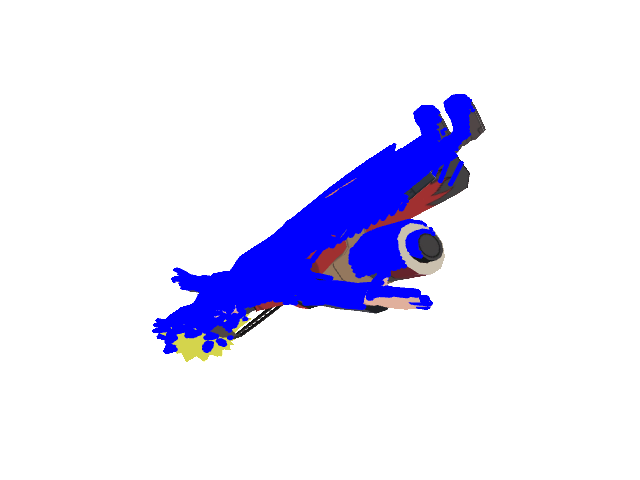

In [28]:
scene.add_points(pc)
i, p, d = scene.sample()
scene.remove_all_points()
i

In [29]:
import open3d as o3d
import numpy as np

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

vertices_to_remove = densities < np.quantile(densities, 0.15)
mesh.remove_vertices_by_mask(vertices_to_remove)

o3d.io.write_triangle_mesh("mesh.obj", mesh)

True

In [ ]:
import numpy as np
import json

cam_pos = np.array([0, 0, 2])
bounds = np.array([
    [-0.810964,  0.001889, -0.810964],
    [ 0.810959,  1.7243  ,  0.810959]
])
bounds[:, 1] -= 1
n_vxls = np.array([300, 300, 300])
volume = np.zeros(n_vxls)
step = (bounds[1] - bounds[0]) / n_vxls

xi = np.arange(n_vxls[0])
yi = np.arange(n_vxls[1])
zi = np.arange(n_vxls[2])
indices = np.stack(np.meshgrid(xi, yi, zi, indexing='ij'), axis=-1)

centers = bounds[0] + step / 2.0 + step * indices
centers = centers.reshape(-1, 3)

num_samples = 50

for i in tqdm(range(num_samples)):

    image, pose, mask = scene.sample()
    
    [x, y, z] = scene.T @ np.linalg.inv(pose[:3, :3]) @ centers.T + cam_pos[:, None]
    x_proj = (_cx + np.rint(x / z * _fx)).astype(np.int32)
    y_proj = (_cy + np.rint(y / z * _fy)).astype(np.int32)
    
    H, W = mask.shape
    valid = (x_proj >= 0) & (x_proj < W) & (y_proj >= 0) & (y_proj < H)
    x_proj = np.clip(x_proj, 0, W-1)
    y_proj = np.clip(y_proj, 0, H-1)
    
    valid_voxels = (valid & (mask[y_proj, x_proj] > 0)).reshape(n_vxls)
    voxel_indices = indices[valid_voxels]
    
    x_idx, y_idx, z_idx = voxel_indices.T
    volume[x_idx, y_idx, z_idx] += 1

data = {
    "version": "Voxel Builder 4.5.1",
    "project": {
        "name": "naruto",
        "voxels": int(np.sum(volume >= num_samples))
    },
    "data": {
        "voxels": ";".join([f"{v[0]},{v[1]},{v[2]},#EE4B2B,1" for v in zip(*np.where(volume >= num_samples))])
    }
}
with open('model.json', 'w') as fp:
    json.dump(data, fp)

In [ ]:
from tqdm.notebook import tqdm
import imageio

animate = True

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
filled = volume >= num_samples
x, y, z = np.nonzero(filled)
project_dir = "./nar"
images_dir = os.path.join(project_dir, "images")
os.makedirs(images_dir, exist_ok=True)

ax.scatter(x, z, y, c='red', marker='s', s=10, alpha=0.5, edgecolors='k', linewidth=0.05)
ax.set_xlim(0, n_vxls[0])
ax.set_ylim(0, n_vxls[1])
ax.set_zlim(0, n_vxls[2])

if animate:

    for i in tqdm(range(360)):
        ax.view_init(azim=i, elev=45)
        plt.savefig(os.path.join(images_dir, f"{i}.png"))
    
    frames = []
    for i in range(360):
        frames.append(imageio.imread(os.path.join(images_dir, f"{i}.png")))
    imageio.mimsave(os.path.join(project_dir, "anime.gif"), frames, format='GIF', fps=30, loop=0)
else:
    ax.view_init(azim=45, elev=45)
    plt.show()